# **Những thay đổi trong bài**
<html>
<table>
    <tr>
        <td colspan="2"></td>
        <th scope="row">Trước</th>
        <th scope="row">Sau</th>
    </tr>
    <tr>
        <th scope="col" rowspan="10">Hyperparameters</th>
        <th scope="row">max_epsilon</th>
        <td align="center">1.0</td>
        <td align="center">1.0</td>
    </tr>
    <tr>
        <th scope="row">min_epsilon</th>
        <td align="center">0.01</td>
        <td align="center">0.01</td>
    </tr>
    <tr>
        <th scope="row">max_num_steps</th>
        <td align="center">50000</td>
        <td align="center"><b>70000</b></td>
    </tr>
    <tr>
        <th scope="row">epsilon_decay_intervals</th>
        <td align="center">10000</td>
        <td align="center"><b>1000</b></td>
    </tr>
    <tr>
        <th scope="row">gamma</th>
        <td align="center">0.99</td>
        <td align="center">0.99</td>
    </tr>
    <tr>
        <th scope="row">alpha</th>
        <td align="center">5e-4</td>
        <td align="center">5e-4</td>
    </tr>
    <tr>
        <th scope="row">memory_size</th>
        <td align="center">50000</td>
        <td align="center"><b>100000</b></td>
    </tr>
    <tr>
        <th scope="row">min_replay_size</th>
        <td align="center">1000</td>
        <td align="center">1000</td>
    </tr>
    <tr>
        <th scope="row">batch_size</th>
        <td align="center">32</td>
        <td align="center"><b>128</b></td>
    </tr>
    <tr>
        <th scope="row">target_update_frequency</th>
        <td align="center">1000</td>
        <td align="center"><b>500</b<</td>
    </tr>
    <tr>
        <th scope="col" colspan="2">Neural Network</th>
        <td>
            nn.Linear(env.observation_space.shape[0], 64),<br />
            nn.Tanh(),<br />
            nn.Linear(64, env.action_space.n)<br />
        </td>
        <td>
            nn.Linear(env.observation_space.shape[0], 64),<br />
            nn.Tanh(),<br />
            nn.Linear(64,32),<br />
            nn.Tanh(),<br />
            nn.Linear(32,16),<br />
            nn.ReLU(),<br />
            nn.Linear(16, env.action_space.n)<br />
        </td>
    </tr>
</table>

</html>

In [15]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

In [16]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

In [17]:
from colabgymrender.recorder import Recorder

In [18]:
# install dependencies
!apt install chromium-browser xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
chromium-browser is already the newest version (1:85.0.4183.83-0ubuntu2.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.10).
0 upgraded, 0 newly installed, 0 to remove and 44 not upgraded.


In [19]:
env = gym.make('MountainCar-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0

while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.play()


  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  if not isinstance(terminated, (bool, np.bool8)):



-200.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [20]:
a = env.action_space.n
print (a)

  and should_run_async(code)



3


In [21]:
total_reward

-200.0

In [22]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 70000
epsilon_decay_intervals = 1000
gamma = 0.99 # discount
alpha = 5e-4 # learning rate

memory_size = 100000
min_replay_size = 1000
batch_size = 128

target_update_frequency = 500 # target network update frequency

In [23]:
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 64),
            nn.Tanh(),
            nn.Linear(64,32),
            nn.Tanh(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16, env.action_space.n)
        )

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch = forward (self.network(state.unsqueeze(0)))
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

In [24]:
def fill_memory(env):
    memory = deque(maxlen=memory_size)
    state = env.reset()
    for _ in range(min_replay_size):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()

    return memory

In [25]:
def dqn_training(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr):
    q_net = NeuralNetwork(env)
    target_net = NeuralNetwork(env)
    target_net.load_state_dict(q_net.state_dict())  #   Nó sao chép tất cả các tham số từ dictionary trả về bởi q_net.state_dict() vào target_net.
    # q_net.state_dict() trả về một dictionnary chứa tất cả các tham số (weights và biases) của các lớp trong q_net

    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)

        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0


        # Take a batch of experiences from the memory
        experiences = random.sample(memory, batch_size)
        states = [ex[0] for ex in experiences]
        actions = [ex[1] for ex in experiences]
        rewards = [ex[2] for ex in experiences]
        dones = [ex[3] for ex in experiences]
        next_states = [ex[4] for ex in experiences]

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        # Compute targets using the formulation sample = r + gamma * max q(s',a')
        target_q_values = target_net(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rewards + gamma * (1-dones) * max_target_q_values

        # Compute loss
        q_values = q_net(states)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(action_q_values, targets)

        # gradient descent for q-network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update target network
        if (step+1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        # print training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')

    return all_rewards, q_net

In [26]:
all_rewards, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

Episode: 5 Step: 1000 Average reward: -200.0
Episode: 10 Step: 2000 Average reward: -200.0
Episode: 15 Step: 3000 Average reward: -198.46666666666667
Episode: 20 Step: 4000 Average reward: -198.85
Episode: 25 Step: 5000 Average reward: -199.08
Episode: 30 Step: 6000 Average reward: -198.1
Episode: 35 Step: 7000 Average reward: -198.37142857142857
Episode: 40 Step: 8000 Average reward: -196.5
Episode: 45 Step: 9000 Average reward: -196.88888888888889
Episode: 50 Step: 10000 Average reward: -196.76
Episode: 55 Step: 11000 Average reward: -197.0
Episode: 60 Step: 12000 Average reward: -197.25
Episode: 65 Step: 13000 Average reward: -197.46153846153845
Episode: 70 Step: 14000 Average reward: -197.45714285714286
Episode: 75 Step: 15000 Average reward: -197.62666666666667
Episode: 80 Step: 16000 Average reward: -197.775
Episode: 85 Step: 17000 Average reward: -197.90588235294118
Episode: 90 Step: 18000 Average reward: -198.0222222222222
Episode: 96 Step: 19000 Average reward: -197.8229166666

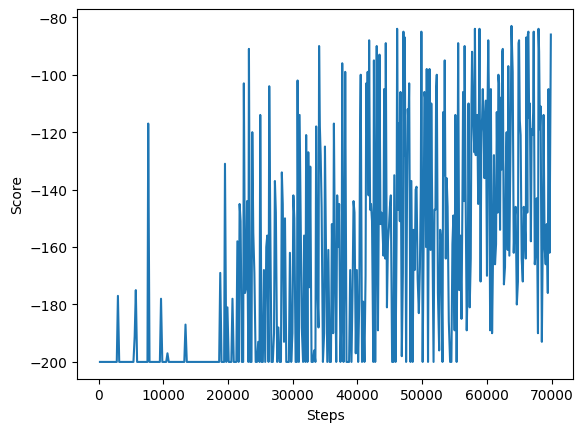

In [27]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

# **Clip giải quyết được tác vụ**

In [28]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-92.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


  and should_run_async(code)

